<a href="https://colab.research.google.com/github/arthurnamz/X-RAY-TB-MODEL/blob/main/finalModel1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import albumentations
import cv2
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision.transforms as transforms
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import torchvision.transforms as transforms

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
BasePath = r'/content/drive/MyDrive/FinalYearProject/TB_Chest_Radiography_Database/'

normal_train = BasePath + "Normal/"
tubor_train = BasePath + "Tuberculosis/"

dataList_train = []

for filename in os.listdir(normal_train):
    file = os.path.join(normal_train, filename)
    #print(file)
    dataList_train += [[file, 0.0]]
for filename in os.listdir(tubor_train):
    file = os.path.join(tubor_train, filename)
    dataList_train += [[file, 1.0]]

In [4]:
df = pd.DataFrame(dataList_train, columns=["Image", "Type"])
#df_test = pd.DataFrame(dataList_test, columns=["Image", "Type"])

In [5]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cpu'

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

In [8]:
X = df.Image.values
y = df.Type.values

In [9]:
(X_train, X_test, y_train, y_test) = (train_test_split(X, y, test_size=0.15))

In [10]:
class CustomDataSet(Dataset):
    def __init__(self, path, labels):
        self.X = path
        self.y = labels

        self.aug = albumentations.Compose([
            albumentations.Resize(32, 32, always_apply=True),
        ])

    def __len__(self):
        return (len(self.X))

    def __getitem__(self, i):
        image = cv2.imread(self.X[i])
        image = self.aug(image=np.array(image))['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        #print(image)
        label = self.y[i]


        return torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.long)

In [11]:
train_data = CustomDataSet(X_train, y_train)
test_data = CustomDataSet(X_test, y_test)

In [12]:
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
test_loader = DataLoader(test_data, batch_size=4, shuffle=False)

In [13]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 =  nn.Conv2d(3, 6, 5)
        self.batch1 = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.batch2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        #self.fc3 = nn.Linear(84, 42)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.batch1(self.conv1(x))))
        x = self.pool(F.relu(self.batch2(self.conv2(x))))
        #x = x.view(-1, 16*5*5)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x - F.relu(self.fc3(x))
        x = self.fc3(x)
        return x

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x

model = Net().to(device)

In [15]:
print(model)

Net(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout2d(p=0.05, inplace=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [16]:
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

5,848,066 total parameters.
5,848,066 training parameters.


In [17]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [18]:
def train(mode, dataloader):
    print("Training")
    model.train()
    running_loss = 0.0
    running_correct = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    train_accuracy = 100 * running_correct/len(dataloader.dataset)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")

    return train_loss, train_accuracy

In [19]:
def validate(model, dataloader):
    print('Validating')
    model.eval()
    running_loss = 0.0
    running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(test_data)/dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, target)

            running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            running_correct += (preds == target).sum().item()

        val_loss = running_loss/len(dataloader.dataset)
        val_accuracy = 100. * running_correct/len(dataloader.dataset)
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')

        return val_loss, val_accuracy

In [20]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
EPOCH = 5
for epoch in range(EPOCH):
    print(f"Epoch {epoch+1} of {EPOCH}")
    train_epoch_loss, train_epoch_accuracy = train(model, train_loader)
    val_epoch_loss, val_epoch_accuracy = validate(model, test_loader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()
print(f"{(end-start)/60:.3f} minutes")

Epoch 1 of 5
Training


893it [42:38,  2.87s/it]


Train Loss: 0.0490, Train Acc: 92.49
Validating


158it [07:17,  2.77s/it]


Val Loss: 0.0140, Val Acc: 98.41
Epoch 2 of 5
Training


893it [02:17,  6.51it/s]                         


Train Loss: 0.0230, Train Acc: 96.95
Validating


158it [00:13, 11.99it/s]


Val Loss: 0.0115, Val Acc: 98.57
Epoch 3 of 5
Training


893it [02:17,  6.48it/s]                         


Train Loss: 0.0171, Train Acc: 97.79
Validating


158it [00:13, 12.01it/s]                         


Val Loss: 0.0142, Val Acc: 99.05
Epoch 4 of 5
Training


893it [02:22,  6.27it/s]


Train Loss: 0.0157, Train Acc: 97.98
Validating


158it [00:12, 12.62it/s]


Val Loss: 0.0112, Val Acc: 98.57
Epoch 5 of 5
Training


893it [02:18,  6.45it/s]                         


Train Loss: 0.0086, Train Acc: 98.91
Validating


158it [00:13, 12.07it/s]                         

Val Loss: 0.0093, Val Acc: 99.05
60.062 minutes


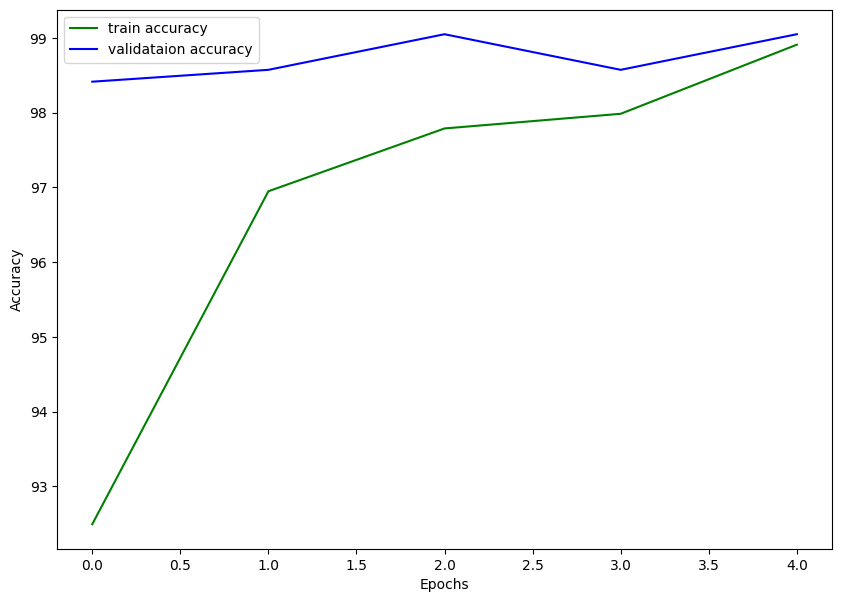

In [21]:
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

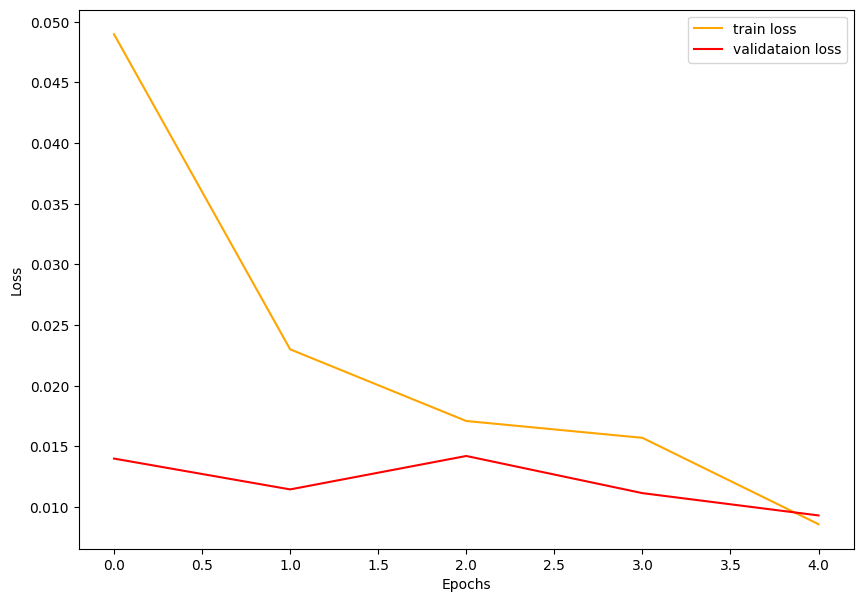

In [22]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()